https://www.bgc-jena.mpg.de/wetter/

# Skip Connection Implementation

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model 

## Data Preprocessing

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [6]:
# feature selection
data_selected = data.iloc[:, [0,1,4,8,16,20]]
display(data_selected.head())

,p (mbar),T (degC),rh (%),sh (g/kg),SWDR (W/m²),CO2 (ppm)
Date Time,,,,,,
01.07.2022 00:10:00,984.33,22.42,84.7,14.67,0.0,447.2
01.07.2022 00:20:00,984.36,22.02,86.8,14.67,0.0,445.6
01.07.2022 00:30:00,984.35,21.77,87.9,14.63,0.0,443.1
01.07.2022 00:40:00,984.27,22.00,85.6,14.45,0.0,443.4
01.07.2022 00:50:00,984.36,22.23,84.0,14.38,0.0,444.4


In [7]:
col_names = list(data_selected.columns)
colors = ['b','g','r','c','m','y']

In [8]:
# for i in range(data_selected.shape[1]):
#     plt.figure(figsize=(15,6))
#     plt.plot(data_selected.iloc[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data_selected)


In [10]:
# train and test split
test_size = 1008
train = data_scaled[:-test_size,:]
test = data_scaled[-test_size:,:]


In [11]:
print(train.size)
print(test.size)

185532
6048


## Amonaly Handling

In [12]:
def plot_histogram(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])

    plt.show()

In [13]:
def plot_boxplot(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])

    plt.show()

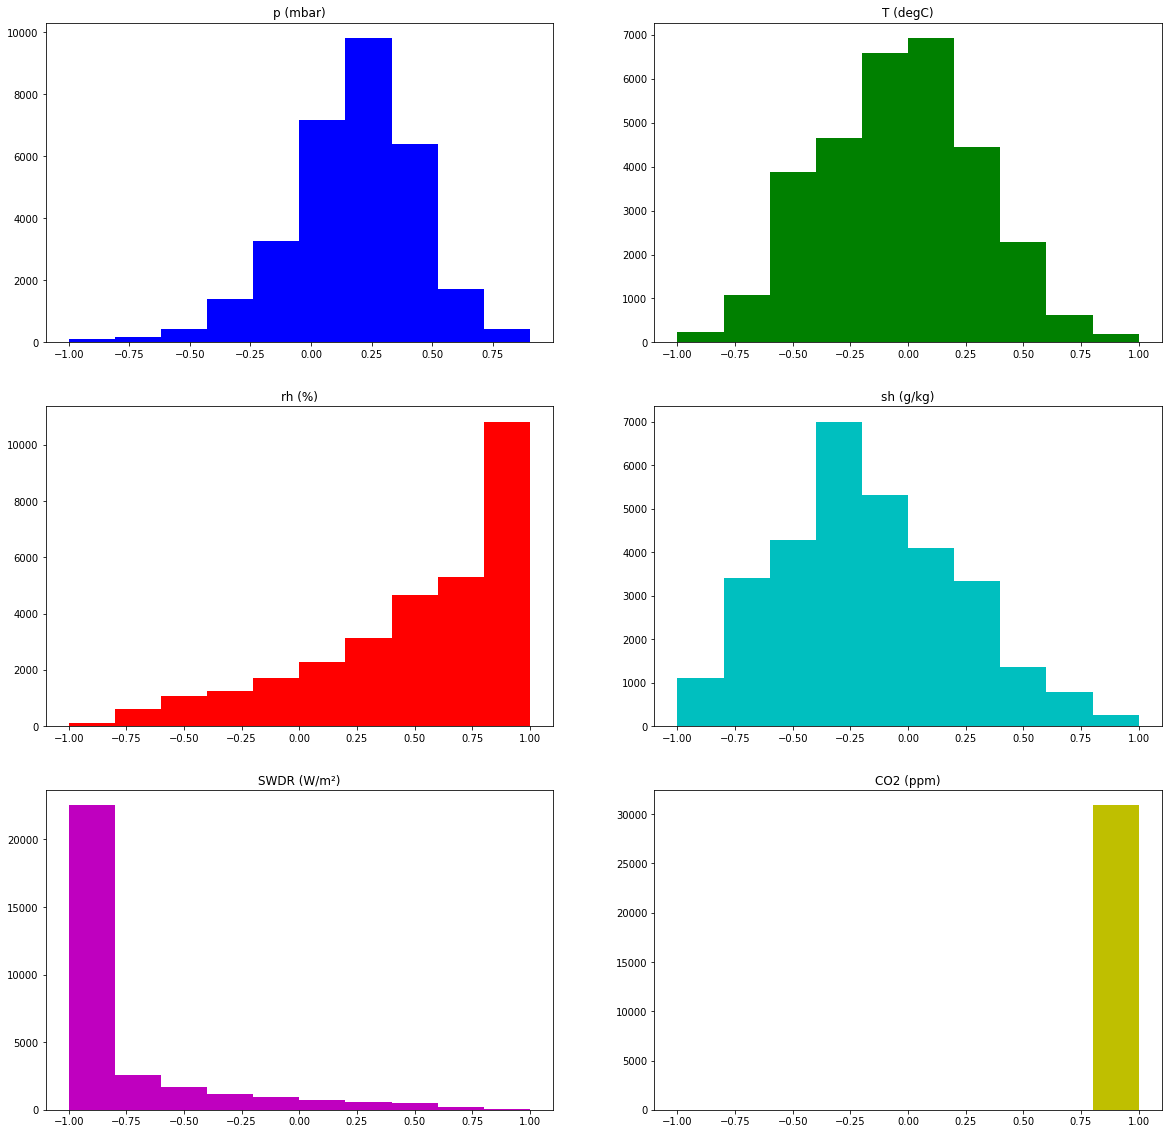

In [14]:
# plot_histogram(3,2,train,col_names,colors)

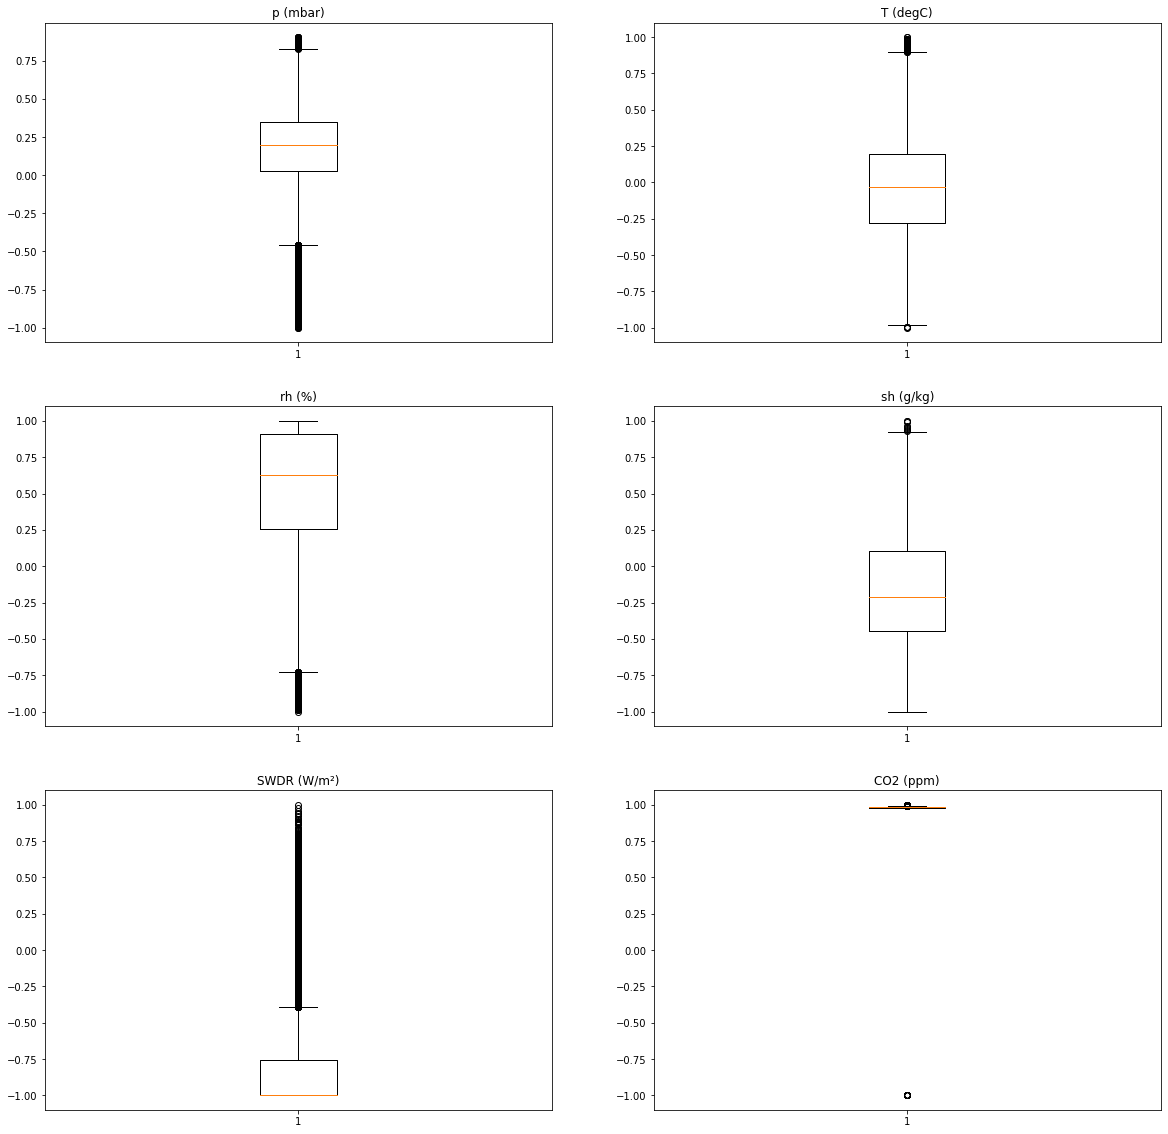

In [15]:
# plot_boxplot(3,2,train,col_names,colors)

In [16]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-100,anomaly_idx_list[i]+101):
            if(train.shape[0]-101>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        if size != 0:
            train[anomaly_idx_list[i],index] = mean/size
    return train

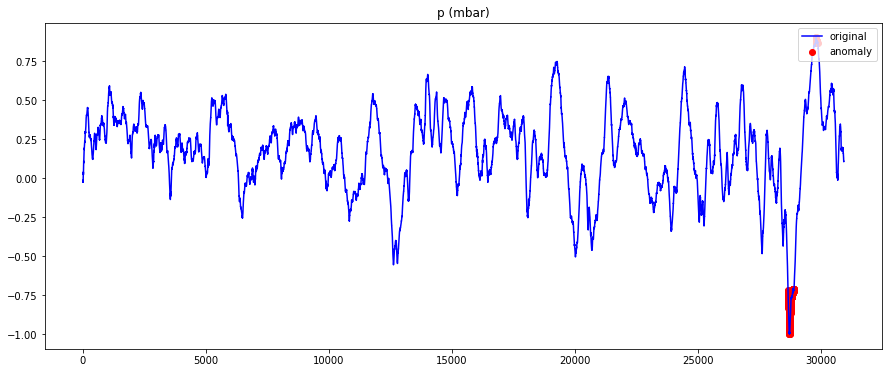

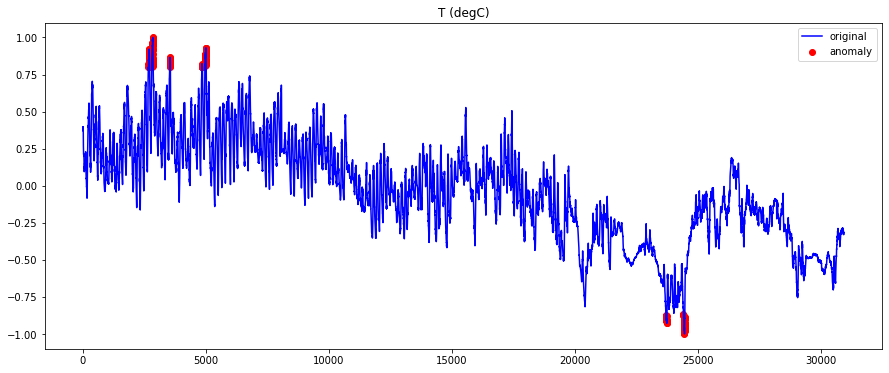

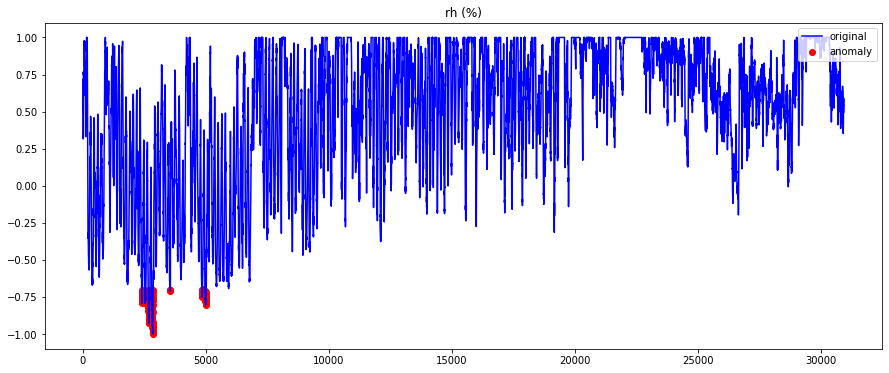

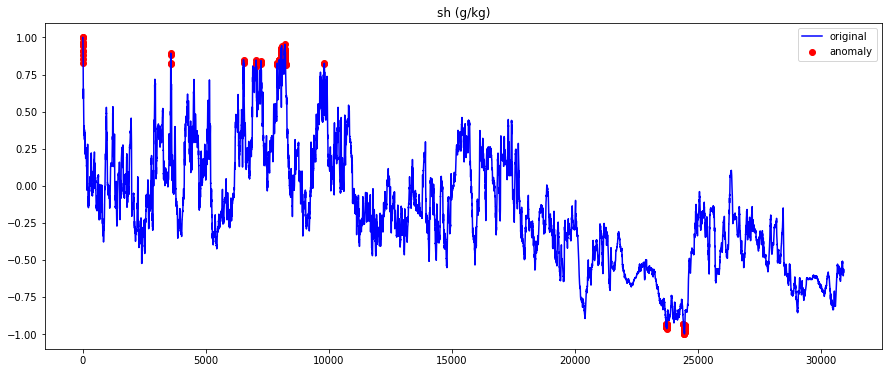

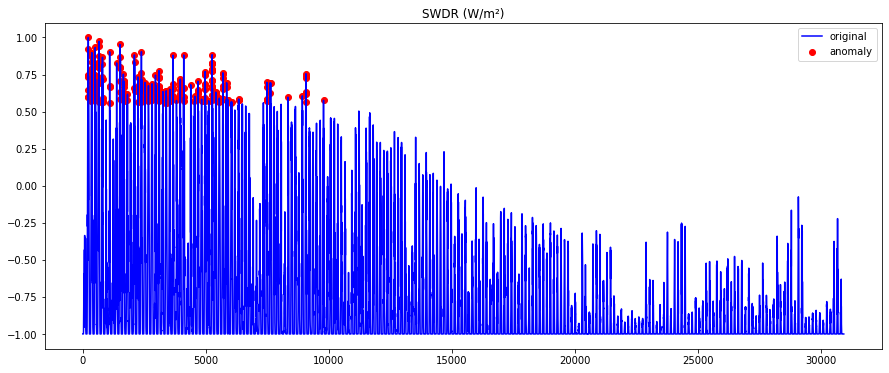

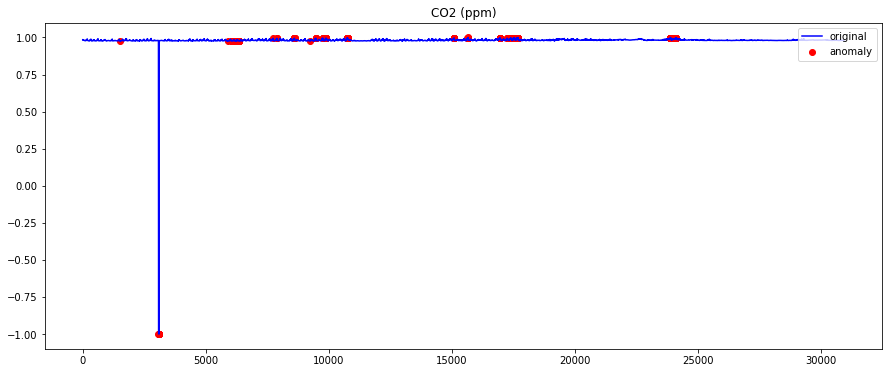

In [17]:
isolation_forest = IsolationForest(contamination=0.01)

for idx in range(train.shape[1]):
    dt_feature = [[item] for item in train[:,idx]]
    isolation_forest.fit(dt_feature)
    pred = isolation_forest.predict(dt_feature)
    anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
    train = remove_anomaly(train,idx,anomaly)
    
    anomaly_val = []
    for i in range(len(anomaly)):
        anomaly_val.append(dt_feature[anomaly[i]])
#     plt.plot(dt_feature,color='b')
#     plt.title(col_names[idx])
#     plt.scatter(anomaly,anomaly_val,color='r')
#     plt.legend(['original','anomaly'], loc='upper right')
#     plt.show()



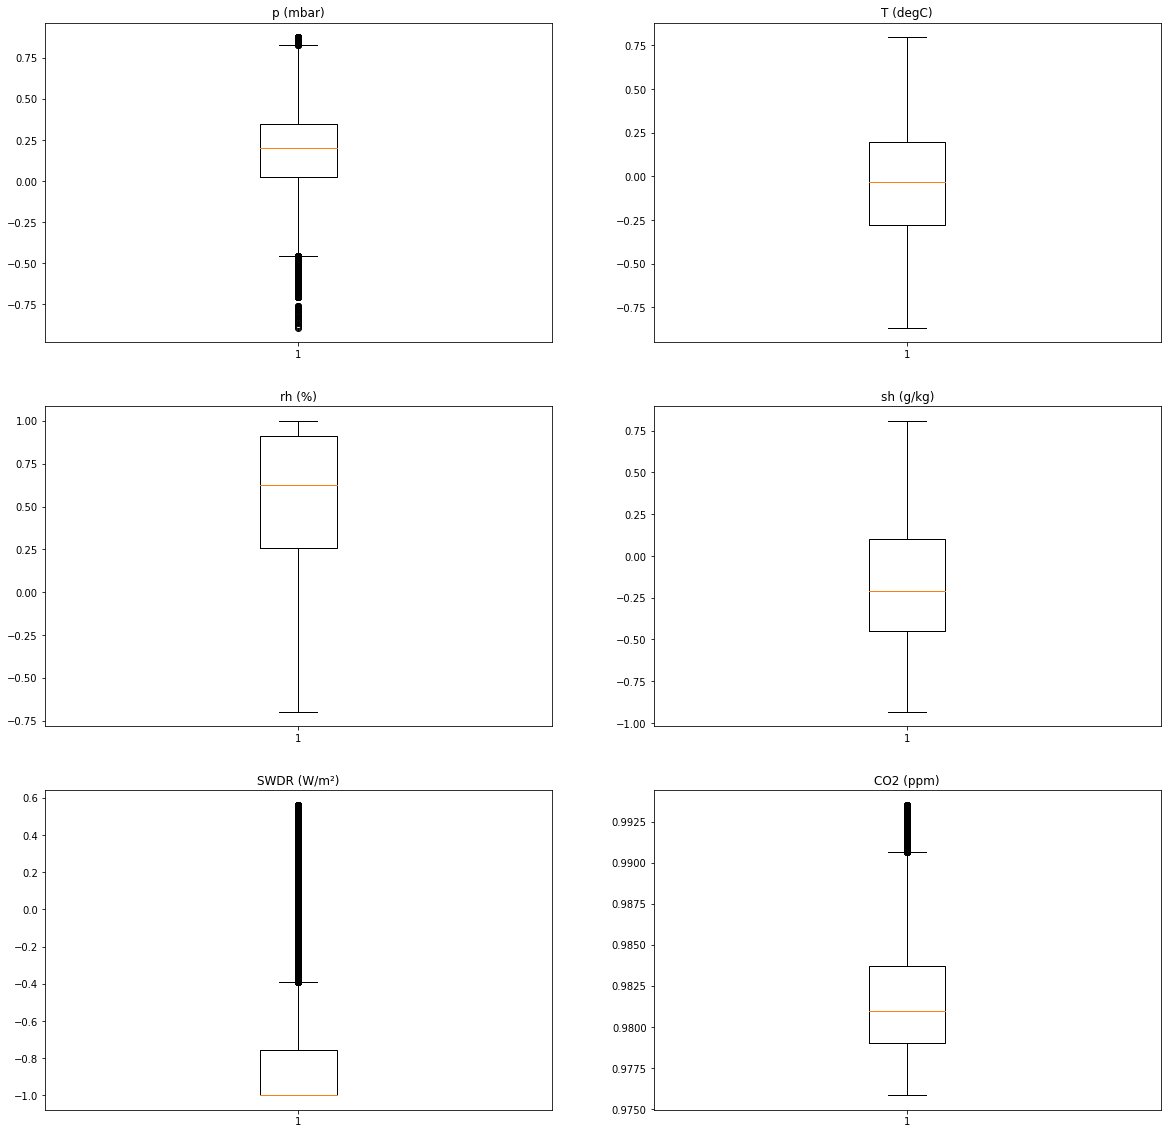

In [18]:
# print(train)
# plot_boxplot(3,2,train,col_names,colors)

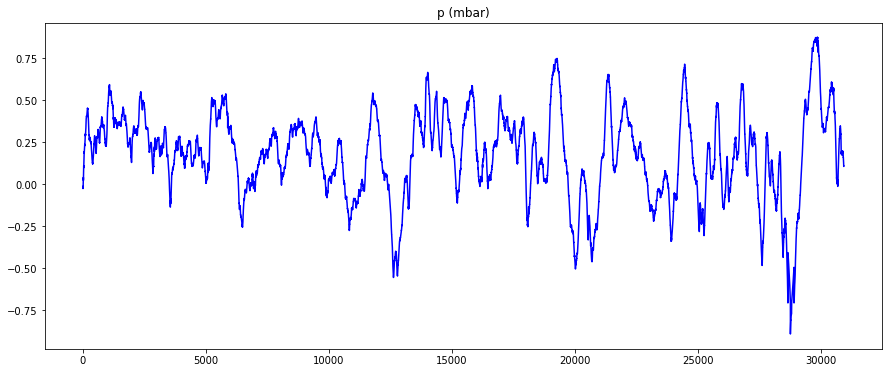

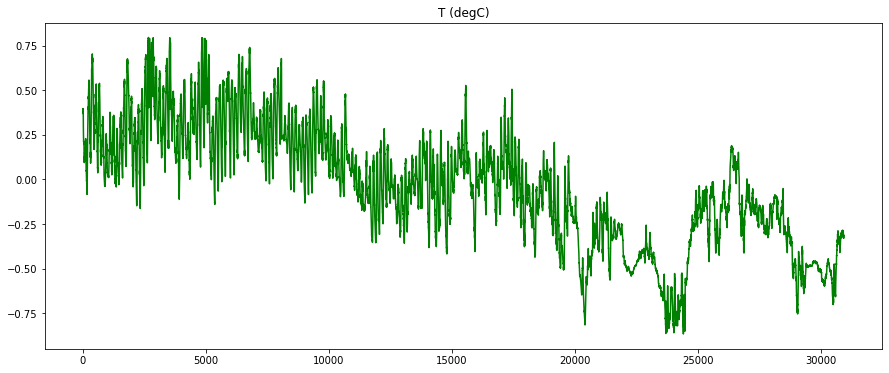

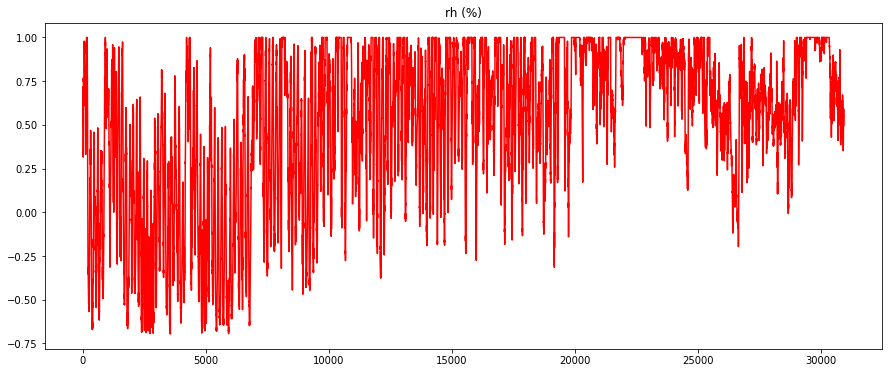

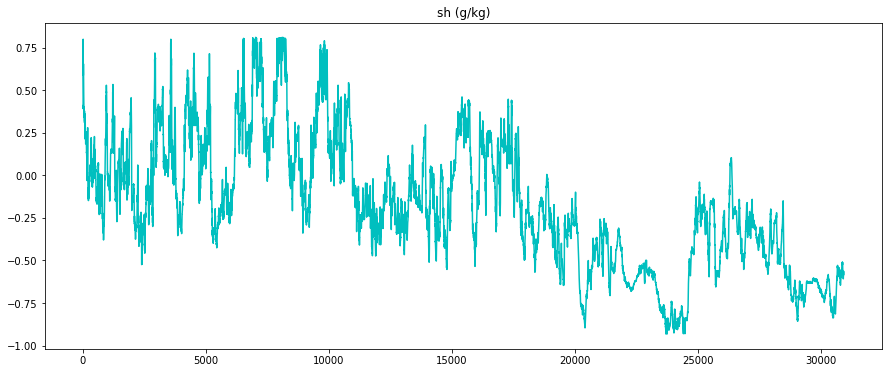

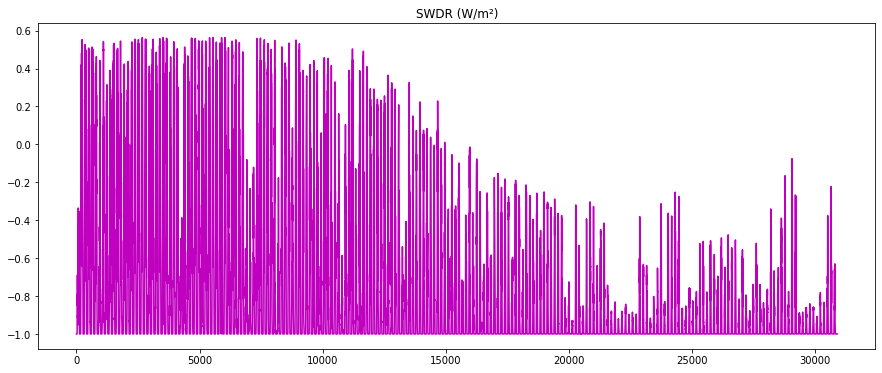

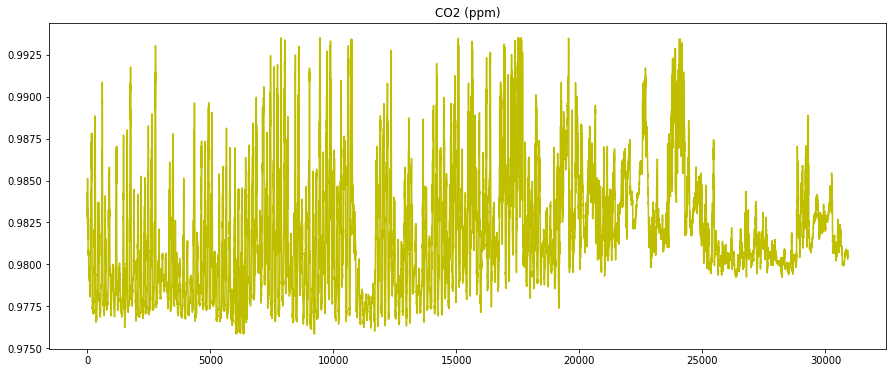

In [19]:
# for i in range(train.shape[1]):
#     plt.plot(train[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()


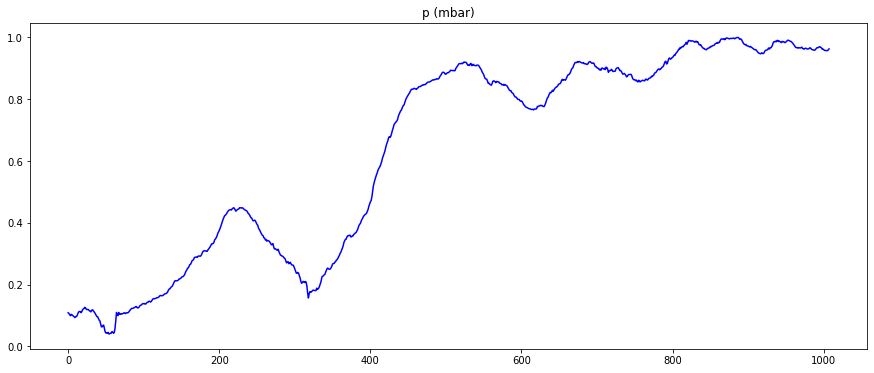

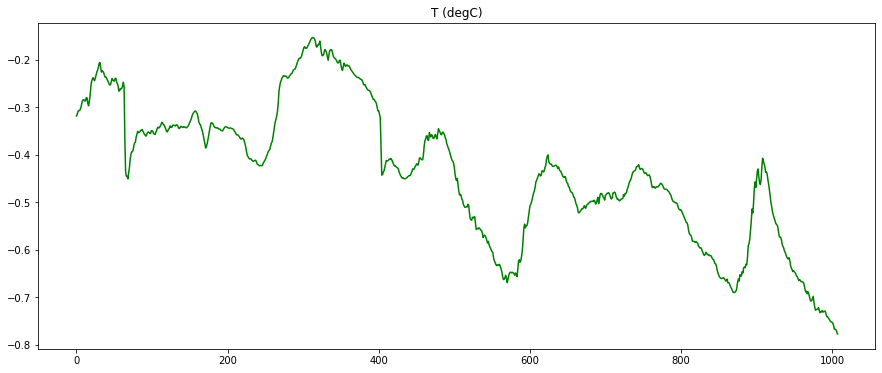

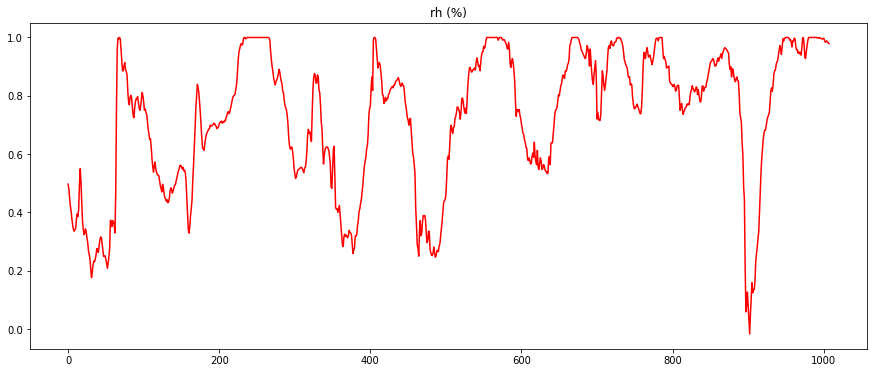

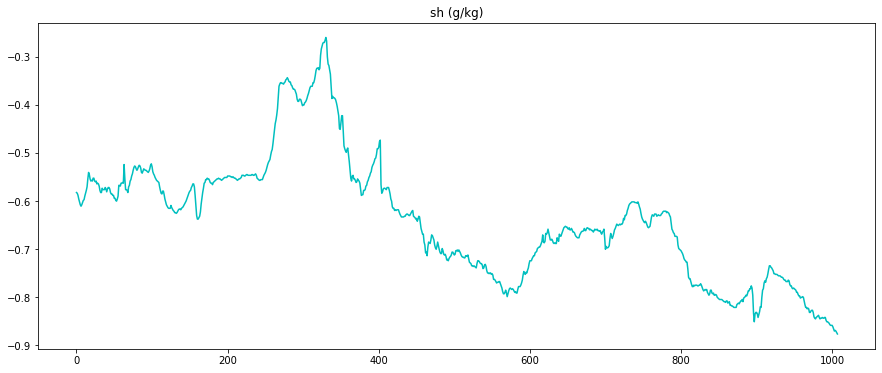

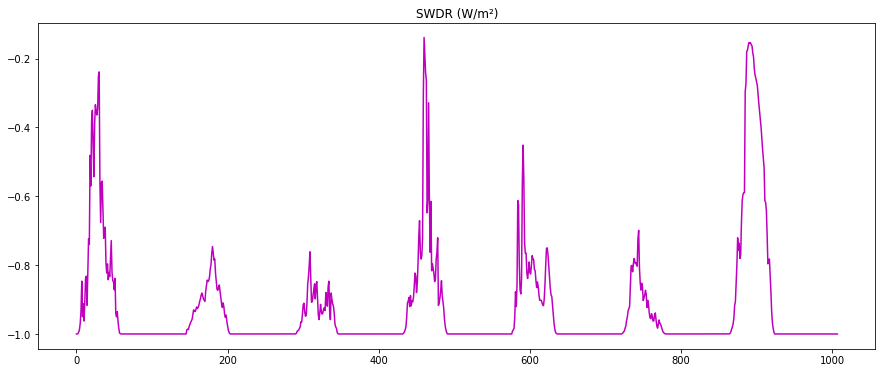

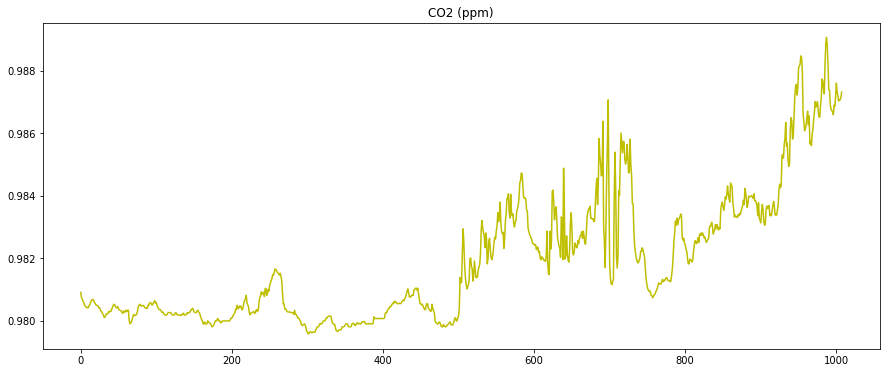

In [20]:
# for i in range(test.shape[1]):
#     plt.plot(test[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

## LSTM Model Implementation

In [21]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
n_features = 6
n_months_in = 150
n_months_out = 100
X_train, y_train = split_sequences(train,n_months_in,n_months_out)
X_test, y_test = split_sequences(test,n_months_in,n_months_out)

In [23]:
print(train.shape)
print(test.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30922, 6)
(1008, 6)
(307, 150, 6) (307, 100, 6)
(8, 150, 6) (8, 100, 6)


In [24]:
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(307, 600)
(8, 600)


In [25]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 150 == 0 and epoch > 0:
        lr = lr * 0.9    
    return lr

# early stopping and model chackpoint
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor="val_loss",verbose=1,patience=100, mode="min",min_delta=0.00001)
model_checkpoint = ModelCheckpoint("best_model.h5",monitor="val_loss",verbose=1,save_best_only=True)


In [36]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=False,recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_months_out*n_features))


In [ ]:
# 
model.compile(optimizer=Adam(learning_rate=0.00075), loss="mse")
epochs = 10000
validation_split = 0.3 # 30% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=147 ,verbose=1,validation_split=validation_split,shuffle=False, callbacks=[learning_rate_scheduler,early_stopping,model_checkpoint])

Epoch 1/10000
2/2 [==============================] - ETA: 0s - loss: 0.3932
Epoch 1: val_loss did not improve from 0.02734
2/2 [==============================] - 7s 1s/step - loss: 0.3932 - val_loss: 0.5162 - lr: 1.0000e-04
Epoch 2/10000
2/2 [==============================] - ETA: 0s - loss: 0.3930
Epoch 2: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 457ms/step - loss: 0.3930 - val_loss: 0.5160 - lr: 1.0000e-04
Epoch 3/10000
2/2 [==============================] - ETA: 0s - loss: 0.3929
Epoch 3: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 457ms/step - loss: 0.3929 - val_loss: 0.5158 - lr: 1.0000e-04
Epoch 4/10000
2/2 [==============================] - ETA: 0s - loss: 0.3927
Epoch 4: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 480ms/step - loss: 0.3927 - val_loss: 0.5156 - lr: 1.0000e-04
Epoch 5/10000
2/2 [==============================] - ETA: 0s - loss: 0.3925
Epoch 5: val_loss d

Epoch 37/10000
2/2 [==============================] - ETA: 0s - loss: 0.3876
Epoch 37: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 475ms/step - loss: 0.3876 - val_loss: 0.5093 - lr: 1.0000e-04
Epoch 38/10000
2/2 [==============================] - ETA: 0s - loss: 0.3874
Epoch 38: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 436ms/step - loss: 0.3874 - val_loss: 0.5091 - lr: 1.0000e-04
Epoch 39/10000
2/2 [==============================] - ETA: 0s - loss: 0.3873
Epoch 39: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 448ms/step - loss: 0.3873 - val_loss: 0.5089 - lr: 1.0000e-04
Epoch 40/10000
2/2 [==============================] - ETA: 0s - loss: 0.3871
Epoch 40: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 467ms/step - loss: 0.3871 - val_loss: 0.5087 - lr: 1.0000e-04
Epoch 41/10000
2/2 [==============================] - ETA: 0s - loss: 0.3870
Epoch 4

Epoch 73/10000
2/2 [==============================] - ETA: 0s - loss: 0.3813
Epoch 73: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 520ms/step - loss: 0.3813 - val_loss: 0.4981 - lr: 1.0000e-04
Epoch 74/10000
2/2 [==============================] - ETA: 0s - loss: 0.3809
Epoch 74: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 450ms/step - loss: 0.3809 - val_loss: 0.4972 - lr: 1.0000e-04
Epoch 75/10000
2/2 [==============================] - ETA: 0s - loss: 0.3806
Epoch 75: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 500ms/step - loss: 0.3806 - val_loss: 0.4962 - lr: 1.0000e-04
Epoch 76/10000
2/2 [==============================] - ETA: 0s - loss: 0.3803
Epoch 76: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 499ms/step - loss: 0.3803 - val_loss: 0.4950 - lr: 1.0000e-04
Epoch 77/10000
2/2 [==============================] - ETA: 0s - loss: 0.3799
Epoch 7

Epoch 109/10000
2/2 [==============================] - ETA: 0s - loss: 0.2261
Epoch 109: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 435ms/step - loss: 0.2261 - val_loss: 0.1042 - lr: 1.0000e-04
Epoch 110/10000
2/2 [==============================] - ETA: 0s - loss: 0.2223
Epoch 110: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 461ms/step - loss: 0.2223 - val_loss: 0.1012 - lr: 1.0000e-04
Epoch 111/10000
2/2 [==============================] - ETA: 0s - loss: 0.2169
Epoch 111: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 469ms/step - loss: 0.2169 - val_loss: 0.0988 - lr: 1.0000e-04
Epoch 112/10000
2/2 [==============================] - ETA: 0s - loss: 0.2113
Epoch 112: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 479ms/step - loss: 0.2113 - val_loss: 0.0970 - lr: 1.0000e-04
Epoch 113/10000
2/2 [==============================] - ETA: 0s - loss: 0.205

2/2 [==============================] - 1s 441ms/step - loss: 0.1350 - val_loss: 0.0931 - lr: 1.0000e-04
Epoch 145/10000
2/2 [==============================] - ETA: 0s - loss: 0.1337
Epoch 145: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 449ms/step - loss: 0.1337 - val_loss: 0.0928 - lr: 1.0000e-04
Epoch 146/10000
2/2 [==============================] - ETA: 0s - loss: 0.1327
Epoch 146: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 465ms/step - loss: 0.1327 - val_loss: 0.0930 - lr: 1.0000e-04
Epoch 147/10000
2/2 [==============================] - ETA: 0s - loss: 0.1323
Epoch 147: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 423ms/step - loss: 0.1323 - val_loss: 0.0930 - lr: 1.0000e-04
Epoch 148/10000
2/2 [==============================] - ETA: 0s - loss: 0.1318
Epoch 148: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 451ms/step - loss: 0.1318 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.1152
Epoch 180: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 441ms/step - loss: 0.1152 - val_loss: 0.0881 - lr: 9.0000e-05
Epoch 181/10000
2/2 [==============================] - ETA: 0s - loss: 0.1155
Epoch 181: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 436ms/step - loss: 0.1155 - val_loss: 0.0879 - lr: 9.0000e-05
Epoch 182/10000
2/2 [==============================] - ETA: 0s - loss: 0.1142
Epoch 182: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 420ms/step - loss: 0.1142 - val_loss: 0.0877 - lr: 9.0000e-05
Epoch 183/10000
2/2 [==============================] - ETA: 0s - loss: 0.1150
Epoch 183: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 446ms/step - loss: 0.1150 - val_loss: 0.0871 - lr: 9.0000e-05
Epoch 184/10000
2/2 [==============================] - ETA: 0s - loss: 0.1141
Epoch 184: val

2/2 [==============================] - 1s 430ms/step - loss: 0.1056 - val_loss: 0.0731 - lr: 9.0000e-05
Epoch 216/10000
2/2 [==============================] - ETA: 0s - loss: 0.1058
Epoch 216: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 459ms/step - loss: 0.1058 - val_loss: 0.0725 - lr: 9.0000e-05
Epoch 217/10000
2/2 [==============================] - ETA: 0s - loss: 0.1068
Epoch 217: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 442ms/step - loss: 0.1068 - val_loss: 0.0718 - lr: 9.0000e-05
Epoch 218/10000
2/2 [==============================] - ETA: 0s - loss: 0.1053
Epoch 218: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 436ms/step - loss: 0.1053 - val_loss: 0.0712 - lr: 9.0000e-05
Epoch 219/10000
2/2 [==============================] - ETA: 0s - loss: 0.1062
Epoch 219: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 432ms/step - loss: 0.1062 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.1002
Epoch 251: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 464ms/step - loss: 0.1002 - val_loss: 0.0605 - lr: 9.0000e-05
Epoch 252/10000
2/2 [==============================] - ETA: 0s - loss: 0.1016
Epoch 252: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 463ms/step - loss: 0.1016 - val_loss: 0.0603 - lr: 9.0000e-05
Epoch 253/10000
2/2 [==============================] - ETA: 0s - loss: 0.0990
Epoch 253: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 446ms/step - loss: 0.0990 - val_loss: 0.0601 - lr: 9.0000e-05
Epoch 254/10000
2/2 [==============================] - ETA: 0s - loss: 0.0997
Epoch 254: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 451ms/step - loss: 0.0997 - val_loss: 0.0599 - lr: 9.0000e-05
Epoch 255/10000
2/2 [==============================] - ETA: 0s - loss: 0.0999
Epoch 255: val

2/2 [==============================] - 1s 438ms/step - loss: 0.0960 - val_loss: 0.0528 - lr: 9.0000e-05
Epoch 287/10000
2/2 [==============================] - ETA: 0s - loss: 0.0960
Epoch 287: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 436ms/step - loss: 0.0960 - val_loss: 0.0526 - lr: 9.0000e-05
Epoch 288/10000
2/2 [==============================] - ETA: 0s - loss: 0.0958
Epoch 288: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 419ms/step - loss: 0.0958 - val_loss: 0.0524 - lr: 9.0000e-05
Epoch 289/10000
2/2 [==============================] - ETA: 0s - loss: 0.0957
Epoch 289: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 449ms/step - loss: 0.0957 - val_loss: 0.0523 - lr: 9.0000e-05
Epoch 290/10000
2/2 [==============================] - ETA: 0s - loss: 0.0970
Epoch 290: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 471ms/step - loss: 0.0970 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0919
Epoch 322: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 445ms/step - loss: 0.0919 - val_loss: 0.0481 - lr: 8.1000e-05
Epoch 323/10000
2/2 [==============================] - ETA: 0s - loss: 0.0943
Epoch 323: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 425ms/step - loss: 0.0943 - val_loss: 0.0480 - lr: 8.1000e-05
Epoch 324/10000
2/2 [==============================] - ETA: 0s - loss: 0.0944
Epoch 324: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 448ms/step - loss: 0.0944 - val_loss: 0.0479 - lr: 8.1000e-05
Epoch 325/10000
2/2 [==============================] - ETA: 0s - loss: 0.0937
Epoch 325: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 447ms/step - loss: 0.0937 - val_loss: 0.0478 - lr: 8.1000e-05
Epoch 326/10000
2/2 [==============================] - ETA: 0s - loss: 0.0934
Epoch 326: val

2/2 [==============================] - 1s 463ms/step - loss: 0.0907 - val_loss: 0.0451 - lr: 8.1000e-05
Epoch 358/10000
2/2 [==============================] - ETA: 0s - loss: 0.0919
Epoch 358: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 439ms/step - loss: 0.0919 - val_loss: 0.0450 - lr: 8.1000e-05
Epoch 359/10000
2/2 [==============================] - ETA: 0s - loss: 0.0908
Epoch 359: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 459ms/step - loss: 0.0908 - val_loss: 0.0449 - lr: 8.1000e-05
Epoch 360/10000
2/2 [==============================] - ETA: 0s - loss: 0.0919
Epoch 360: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 456ms/step - loss: 0.0919 - val_loss: 0.0449 - lr: 8.1000e-05
Epoch 361/10000
2/2 [==============================] - ETA: 0s - loss: 0.0906
Epoch 361: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 459ms/step - loss: 0.0906 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0889
Epoch 393: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 499ms/step - loss: 0.0889 - val_loss: 0.0426 - lr: 8.1000e-05
Epoch 394/10000
2/2 [==============================] - ETA: 0s - loss: 0.0889
Epoch 394: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 472ms/step - loss: 0.0889 - val_loss: 0.0426 - lr: 8.1000e-05
Epoch 395/10000
2/2 [==============================] - ETA: 0s - loss: 0.0883
Epoch 395: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 449ms/step - loss: 0.0883 - val_loss: 0.0426 - lr: 8.1000e-05
Epoch 396/10000
2/2 [==============================] - ETA: 0s - loss: 0.0900
Epoch 396: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 467ms/step - loss: 0.0900 - val_loss: 0.0425 - lr: 8.1000e-05
Epoch 397/10000
2/2 [==============================] - ETA: 0s - loss: 0.0890
Epoch 397: val

2/2 [==============================] - 1s 442ms/step - loss: 0.0862 - val_loss: 0.0413 - lr: 8.1000e-05
Epoch 429/10000
2/2 [==============================] - ETA: 0s - loss: 0.0867
Epoch 429: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 456ms/step - loss: 0.0867 - val_loss: 0.0413 - lr: 8.1000e-05
Epoch 430/10000
2/2 [==============================] - ETA: 0s - loss: 0.0861
Epoch 430: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 447ms/step - loss: 0.0861 - val_loss: 0.0412 - lr: 8.1000e-05
Epoch 431/10000
2/2 [==============================] - ETA: 0s - loss: 0.0871
Epoch 431: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 448ms/step - loss: 0.0871 - val_loss: 0.0411 - lr: 8.1000e-05
Epoch 432/10000
2/2 [==============================] - ETA: 0s - loss: 0.0869
Epoch 432: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 475ms/step - loss: 0.0869 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0841
Epoch 464: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 454ms/step - loss: 0.0841 - val_loss: 0.0400 - lr: 7.2900e-05
Epoch 465/10000
2/2 [==============================] - ETA: 0s - loss: 0.0847
Epoch 465: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 446ms/step - loss: 0.0847 - val_loss: 0.0399 - lr: 7.2900e-05
Epoch 466/10000
2/2 [==============================] - ETA: 0s - loss: 0.0842
Epoch 466: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 434ms/step - loss: 0.0842 - val_loss: 0.0398 - lr: 7.2900e-05
Epoch 467/10000
2/2 [==============================] - ETA: 0s - loss: 0.0847
Epoch 467: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 438ms/step - loss: 0.0847 - val_loss: 0.0398 - lr: 7.2900e-05
Epoch 468/10000
2/2 [==============================] - ETA: 0s - loss: 0.0832
Epoch 468: val

2/2 [==============================] - 1s 508ms/step - loss: 0.0817 - val_loss: 0.0394 - lr: 7.2900e-05
Epoch 500/10000
2/2 [==============================] - ETA: 0s - loss: 0.0815
Epoch 500: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 507ms/step - loss: 0.0815 - val_loss: 0.0395 - lr: 7.2900e-05
Epoch 501/10000
2/2 [==============================] - ETA: 0s - loss: 0.0805
Epoch 501: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 453ms/step - loss: 0.0805 - val_loss: 0.0393 - lr: 7.2900e-05
Epoch 502/10000
2/2 [==============================] - ETA: 0s - loss: 0.0818
Epoch 502: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 549ms/step - loss: 0.0818 - val_loss: 0.0391 - lr: 7.2900e-05
Epoch 503/10000
2/2 [==============================] - ETA: 0s - loss: 0.0813
Epoch 503: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 514ms/step - loss: 0.0813 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0776
Epoch 535: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 445ms/step - loss: 0.0776 - val_loss: 0.0378 - lr: 7.2900e-05
Epoch 536/10000
2/2 [==============================] - ETA: 0s - loss: 0.0775
Epoch 536: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 409ms/step - loss: 0.0775 - val_loss: 0.0379 - lr: 7.2900e-05
Epoch 537/10000
2/2 [==============================] - ETA: 0s - loss: 0.0771
Epoch 537: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 438ms/step - loss: 0.0771 - val_loss: 0.0381 - lr: 7.2900e-05
Epoch 538/10000
2/2 [==============================] - ETA: 0s - loss: 0.0772
Epoch 538: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 457ms/step - loss: 0.0772 - val_loss: 0.0382 - lr: 7.2900e-05
Epoch 539/10000
2/2 [==============================] - ETA: 0s - loss: 0.0790
Epoch 539: val

2/2 [==============================] - 1s 450ms/step - loss: 0.0748 - val_loss: 0.0369 - lr: 7.2900e-05
Epoch 571/10000
2/2 [==============================] - ETA: 0s - loss: 0.0761
Epoch 571: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 419ms/step - loss: 0.0761 - val_loss: 0.0370 - lr: 7.2900e-05
Epoch 572/10000
2/2 [==============================] - ETA: 0s - loss: 0.0765
Epoch 572: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 446ms/step - loss: 0.0765 - val_loss: 0.0370 - lr: 7.2900e-05
Epoch 573/10000
2/2 [==============================] - ETA: 0s - loss: 0.0739
Epoch 573: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 451ms/step - loss: 0.0739 - val_loss: 0.0369 - lr: 7.2900e-05
Epoch 574/10000
2/2 [==============================] - ETA: 0s - loss: 0.0752
Epoch 574: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 431ms/step - loss: 0.0752 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0716
Epoch 606: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 422ms/step - loss: 0.0716 - val_loss: 0.0355 - lr: 6.5610e-05
Epoch 607/10000
2/2 [==============================] - ETA: 0s - loss: 0.0728
Epoch 607: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 462ms/step - loss: 0.0728 - val_loss: 0.0353 - lr: 6.5610e-05
Epoch 608/10000
2/2 [==============================] - ETA: 0s - loss: 0.0716
Epoch 608: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 448ms/step - loss: 0.0716 - val_loss: 0.0353 - lr: 6.5610e-05
Epoch 609/10000
2/2 [==============================] - ETA: 0s - loss: 0.0739
Epoch 609: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 426ms/step - loss: 0.0739 - val_loss: 0.0356 - lr: 6.5610e-05
Epoch 610/10000
2/2 [==============================] - ETA: 0s - loss: 0.0716
Epoch 610: val

In [ ]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Prediction

In [ ]:
# load model
model = load_model('best_model.h5')

In [ ]:
"""
    1. Create y_pred array and X_test_model.
    2. y_pred is for saving predicted test values. Its shape is the same as y_test.
    3. X_test_model is for step by step prediction. Firstly X_test_model is equal to 
       the first input of LSTM model which is X_test[0]. X_test[0]'s shape is equal to (n_steps_in,n_features).
"""

y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = X_test[0].copy()


In [ ]:
"""
    Predict y values of test set step by step. At the beginning X_test_model is equal to X_test[0].
    Predicted values are store in "pred" variable. Then predicted values are copied to "y_pred" variable's 
    corresponding row. After that X_test_model is shifted by n_steps_out and the last n_steps_out number of values
    in X_test_model replaced with predicted values.
    
"""
for i in range(X_test.shape[0]):

    X_test_model = X_test_model.reshape(1,n_steps_in,n_features)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_steps_in,n_features)
    y_pred[i]=pred
    pred=pred.reshape(n_steps_out,n_features)
    if(n_steps_out>n_steps_in):
        X_test_model[0,:] = pred[-n_steps_in:]
    else:
        X_test_model[0,:-n_steps_out] = X_test_model[0,n_steps_out:]
        X_test_model[0,-n_steps_out:] = pred
    

In [ ]:
# inverse scaling
y_pred_inv = np.zeros_like(y_pred)
y_test_inv = np.zeros_like(y_test)
for i in range(1,n_months_out+1):
    y_pred_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred[:,(i-1)*n_features:i*n_features])
    
    y_test_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_test[:,(i-1)*n_features:i*n_features])

    rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

In [ ]:
# reshape y sets and calculate mse
y_test_re = y_test_inv.reshape(n_months_out*y_test_inv.shape[0], n_features)
y_pred_re = y_pred_inv.reshape(n_months_out*y_pred_inv.shape[0], n_features)
print(y_pred_re.shape)
print(y_test_re.shape)
rmse = mean_squared_error(y_test_re, y_pred_re) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

In [ ]:
# print(y_pred_re[:10,])
# print(y_test_re[:10,])

In [ ]:
# plot predicted and actual y values of the test set
for i in range(n_features):
    plt.plot(y_test_re[:,i],color='black')
    plt.plot(y_pred_re[:,i],color='red')
    plt.legend(["test","predicted"])
    plt.title(col_names[i])
    plt.show()
